In [11]:
include("../code/julia/ha-trade-environment.jl")
include("../code/julia/ha-trade-solution.jl")
include("../code/julia/ha-trade-helper-functions.jl")
include("../code/julia/static-trade-environment.jl")

using FiniteDifferences
using Plots
using CSV
using DataFrames

In [33]:
Ncntry = 2

dtest = 1.75
d = dtest.*ones(Ncntry,Ncntry)
d[diagind(d)] .= 1.0

mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, 
γ = 1.5, ϕ = 2.0, amax = 8.0, σϵ = 0.25, d = d, TFP = [1.0, 1.0], L = [1.0, 1.0])

@unpack Na, Nshocks, Ncntry, TFP = mdl_prm

R = 1.0246*ones(Ncntry);
W = 1.0*ones(Ncntry);

In [34]:
@time Y, tradeflows, A_demand, tradeshare, hh, dist = world_equillibrium(R, W, mdl_prm, hh_solution_method = "itteration");

  0.379200 seconds (147.79 k allocations: 100.418 MiB)


In [35]:
A_demand

2-element Vector{Float64}:
 0.0009738442317995255
 0.0009738442317995255

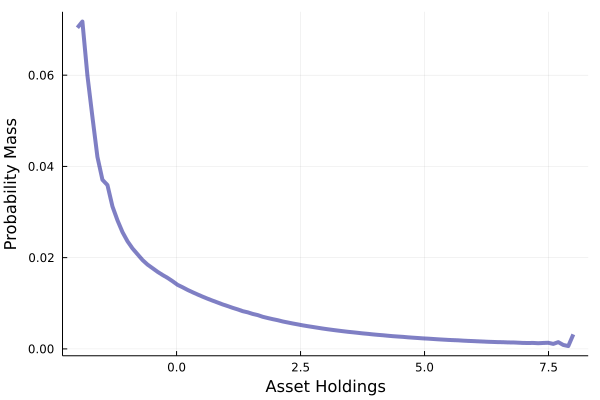

In [36]:
adist = get_distribution(dist[1].state_index, dist[1].λ);

plot(mdl_prm.agrid, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)

In [39]:
function make_Mij_Mii(∂d, R, W, home, source, model_params)

    p = make_p(∂d, W, home, source, model_params)

    hh = solve_household_problem(R, W, p, model_params, solution_method = "itteration", tol = 1e-10)
    #itteration is not working properly...need to fix, nlfixed point yes

    state_index = Array{Tuple{eltype(Int64), eltype(Int64)}}(undef, model_params.Na*model_params.Nshocks, 1)
    
    make_state_index!(state_index, model_params)

    pcπ_by_state , πprob_by_state, pc_by_state = get_trade(R, W, hh.asset_policy, hh.πprob, state_index, model_params)

    Mij_Mii_total = (pcπ_by_state[:,source]) ./ (pcπ_by_state[:,home])
    
    Mij_Mii_imargin = (pc_by_state[:,source]) ./ (pc_by_state[:,home])
    
    Mij_Mii_xmargin = (πprob_by_state[:,source]) ./ (πprob_by_state[:,home])

    return Mij_Mii_total, Mij_Mii_imargin, Mij_Mii_xmargin

end

function make_p(∂d, W, home, source, model_params)

    @unpack TFP, d = model_params

    p = (W ./ TFP[home] ) .* d[home, :]

    p[source] = (W ./ TFP[home] )*∂d

    return p

end

function make_dataset(∂logM_∂logd, model_params)
    
    elasticity_mat = Array{eltype(∂logM_∂logd)}(undef, model_params.Na, model_params.Nshocks)
    
    state_index = Array{Tuple{eltype(Int64), eltype(Int64)}}(undef, model_params.Na*model_params.Nshocks, 1)
    
    make_state_index!(state_index, model_params)
    
    for (foo, xxx) in enumerate(state_index)
        
        elasticity_mat[xxx[1], xxx[2]] = ∂logM_∂logd[foo]
    end
    
    return elasticity_mat
    
end

function make_dataset_dataframe(∂logM_∂logd, model_params)
    
    elasticity = Array{eltype(∂logM_∂logd)}(undef, model_params.Na*model_params.Nshocks)
    shock = Array{eltype(∂logM_∂logd)}(undef, model_params.Na*model_params.Nshocks)
    asset = Array{eltype(∂logM_∂logd)}(undef, model_params.Na*model_params.Nshocks)
    
    state_index = Array{Tuple{eltype(Int64), eltype(Int64)}}(undef, model_params.Na*model_params.Nshocks, 1)
    
    make_state_index!(state_index, model_params)
    
    for (foo, xxx) in enumerate(state_index)
        
        shock[foo] = xxx[2]
        
        asset[foo] = model_params.agrid[xxx[1]]
        
        elasticity[foo] = ∂logM_∂logd[foo]
    end
    
    df = DataFrame(asset = asset, 
               shock = shock,
               elasticity = elasticity, 
               );
    
    return df
    
end     

make_dataset_dataframe (generic function with 1 method)

In [44]:
home = 1

source = 2

h(x) = make_Mij_Mii(x[1], R[home], W[home], home, source, mdl_prm)[1]

∂M_∂d = jacobian(central_fdm(2, 1), h, [dtest])[1]

∂logM_∂logd = ∂M_∂d .* (dtest ./ h(dtest));

df = make_dataset_dataframe(∂logM_∂logd, mdl_prm)

CSV.write("elasticity_total.csv", df)

"elasticity_total.csv"

In [45]:
df = make_dataset_dataframe(h(dtest), mdl_prm)

CSV.write("trade_share.csv", df)

"trade_share.csv"

In [46]:
df


,asset,shock,elasticity
,Float64,Float64,Float64
1,-2.0,1.0,0.00478748
2,-1.89899,1.0,0.0129305
3,-1.79798,1.0,0.0166443
4,-1.69697,1.0,0.0218334
5,-1.59596,1.0,0.0243266
6,-1.49495,1.0,0.0271639
7,-1.39394,1.0,0.0301253
8,-1.29293,1.0,0.0327762
9,-1.19192,1.0,0.0349784
